In [12]:
%bash
pip install pip==9.0.3
bq mk demos
bq rm -f demos.data
bq load \
   --source_format=CSV \
   demos.data \
   gs://5or10/5000.csv \
   image_url:string,label:string

  Using cached https://files.pythonhosted.org/packages/ac/95/a05b56bb975efa78d3557efa36acaf9cf5d2fd0ee0062060493687432e03/pip-9.0.3-py2.py3-none-any.whl
  Found existing installation: pip 18.1
    Uninstalling pip-18.1:
      Successfully uninstalled pip-18.1
BigQuery error in mk operation: Dataset 'mlbootcamp082019:demos' already exists.


In [13]:
import google.datalab.bigquery as bq
import matplotlib.pyplot as plt

sql = "SELECT image_url, label FROM mlbootcamp082019.demos.data"
df = bq.Query(sql).execute().result().to_dataframe()
print 'Have a total of {} labeled images'.format(len(df))
df.head()

Have a total of 158 labeled images


,image_url,label
0,gs://5or10/NotesDS/5000/2019-08-10-114740_1.jpg,5000
1,gs://5or10/NotesDS/5000/2019-08-10-114740_2.jpg,5000
2,gs://5or10/NotesDS/5000/2019-08-10-114740_3.jpg,5000
3,gs://5or10/NotesDS/5000/2019-08-10-114740_4.jpg,5000
4,gs://5or10/NotesDS/5000/2019-08-10-114804_1.jpg,5000


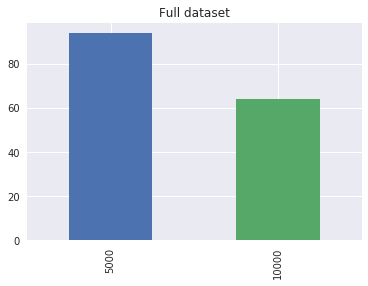

In [9]:
df['label'].value_counts().plot(kind='bar', title='Full dataset');

<h2>Create bucket</h2>
<p>
Create a new bucket to hold your model etc. At the end of this demo, you can delete that bucket.

In [19]:
bucket = 'gs://' + datalab_project_id() + '-txf'
preprocessed_dir = bucket + '/preprocessed'
model_dir = bucket + '/model'

In [10]:
import subprocess
print 'Creating bucket named {}'.format(bucket)
subprocess.check_call('gsutil mb {}'.format(bucket).split());

<h2> Preprocessing </h2>
<p>
Now that we have the images in Cloud Storage and the labels in BigQuery, we can use Datalab's ML Toolbox to do transfer learning. This consists of three steps: (1) Preprocessing (2) Training, and (3) Deploying.

Preprocessing the images will resize the images, and do some image augmentation. You can set @param: 'max_num_workers' = 4 ~ 30 min. But if you set 10 like me it ~ 26 min. So you can set 4 it would be more economical.

In [15]:
import mltoolbox.image.classification as model
from google.datalab.ml import *
import os

train_set = BigQueryDataSet("SELECT image_url, label FROM mlbootcamp082019.demos.data")
print(train_set.sample(10))

if train_set is not None: 
    job = model.preprocess_async(train_set, preprocessed_dir, cloud={'max_num_workers': 10}) #set it 4 if you want

# job = model.preprocess_async(train_set, preprocessed_dir) #for local preprocess

Job "preprocess-image-classification-190810-121538" submitted. Click here to track preprocessing job.

In [16]:
# Wait for your preprocessing job to complete.
# If you choose this option, uncomment the next line and run this cell.
job.wait()

Job preprocess-image-classification-190810-121538 completed

If you don't want to wait just copy my preprocessed data and do the last part.

In [54]:
# %bash
# # Copy my preprocessing results and move on.
# # If you choose this option, uncomment the last two lines and run this cell.
# FROM=gs://mlbootcamp082019-txf/preprocessed
# TO="gs://${PROJECT_ID}-txf"
# echo "Copying already preprocessed files from $FROM to $TO"
# gsutil -m cp -r $FROM $TO

<h2> Training </h2>
<p>
Train the last few layers of the inception model based on our images.

In [17]:
import mltoolbox.image.classification as model
from google.datalab.ml import *
job = model.train_async(preprocessed_dir, 32, 5000, model_dir,  # batchsize, numsteps
                  cloud=CloudTrainingConfig('us-central1', 'BASIC'))

Job "image_classification_train_190810_124436" submitted. Click here to view cloud log.

Wait for the above job to complete before proceeding to next step (monitor job progress on the GCP console under ML Engine | Jobs).  It should take about 15 minutes to complete.
The training log may contain harmless warnings and errors. Please check the message `Task completed successfully` at the end of the log to confirm the successful completion.
<p>
<h2> Evaluation </h2>

In [25]:
from google.datalab.ml import *
tb_id = TensorBoard.start(model_dir)

gs://mlbootcamp082019-txf/model


In [11]:
TensorBoard.stop(tb_id)


<p>
<h2> Deploy and predict model </h2>
<p>
Deploy the trained model as a web service. This simply a short cut to the underlying gcloud commands.

In [32]:
Models().create('fiveor10000')
ModelVersions('fiveor10000').deploy('v1', model_dir)

Waiting for operation "projects/mlbootcamp082019/operations/create_fiveor10000_v1-1565442969572"
Done.


Once the model is deployed, we can send along an image and we will get back the classification probabilities. (these images are not among the 200 or so images used in training or in evaluation)

Predicting...


10000(1.00000)

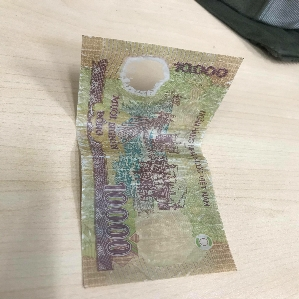

,image_url,label,score
0,gs://5or10/67969363_2585090534868345_865433220...,10000,0.999998


In [33]:
images = ["gs://5or10/67969363_2585090534868345_8654332206354792448_n.jpg"]
# resize=True because otherwise the images are too large to send for online prediction.
model.predict('fiveor10000.v1', images, resize=True, cloud=True)